# Homework - Classification III

***Agata Makarewicz***

*Week 10 & 11*

In [1]:
# loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
import scikitplot as skplt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from scipy.stats import loguniform, uniform, randint
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [2]:
data_train = pd.read_csv('train.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])
data_test = pd.read_csv('test.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])
mapper = pd.read_parquet('id_map.parquet')

In [3]:
print('Train dataset: {0} records, {1} columns'.format(data_train.shape[0], data_train.shape[1]))
print('Test dataset: {0} records, {1} columns'.format(data_test.shape[0], data_test.shape[1]))
print('Mapping dataset: {0} records, {1} columns'.format(mapper.shape[0], mapper.shape[1]))

Train dataset: 159969 records, 21 columns
Test dataset: 93338 records, 20 columns
Mapping dataset: 48371 records, 2 columns


In [4]:
data_train.head()

,webpage1,time1,webpage2,time2,webpage3,time3,webpage4,time4,webpage5,time5,webpage6,time6,webpage7,time7,webpage8,time8,webpage9,time9,webpage10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
0,9486,2019-02-20 05:57:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
1,11722,2019-02-22 07:14:50,12385.0,2019-02-22 07:14:50,50163.0,2019-02-22 07:14:51,12385.0,2019-02-22 07:14:51,12398.0,2019-02-22 07:14:51,50150.0,2019-02-22 07:14:51,50163.0,2019-02-22 07:14:52,50150.0,2019-02-22 07:14:52,19860.0,2019-02-22 07:15:15,19886.0,2019-02-22 07:15:16,0
2,192149,2018-12-16 12:35:17,659.0,2018-12-16 12:35:18,192136.0,2018-12-16 12:35:19,192149.0,2018-12-16 12:35:19,633.0,2018-12-16 12:35:19,659.0,2018-12-16 12:35:19,192136.0,2018-12-16 12:35:20,192136.0,2018-12-16 12:35:21,192136.0,2018-12-16 12:35:22,192136.0,2018-12-16 12:35:24,0
3,10591,2019-02-13 12:40:35,451.0,2019-02-13 12:40:35,77580.0,2019-02-13 12:40:35,227821.0,2019-02-13 12:40:35,633.0,2019-02-13 12:41:05,425.0,2019-02-13 12:42:14,10591.0,2019-02-13 12:42:14,227834.0,2019-02-13 12:42:15,227834.0,2019-02-13 12:42:16,227834.0,2019-02-13 12:42:17,0
4,438,2018-04-12 06:22:26,425.0,2018-04-12 06:22:26,529.0,2018-04-12 06:22:28,65685.0,2018-04-12 06:22:29,187638.0,2018-04-12 06:22:29,451.0,2018-04-12 06:22:29,425.0,2018-04-12 06:22:29,65685.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:31,187625.0,2018-04-12 06:22:32,0


In [5]:
def preproc(df):
    return (
        df.assign(
            # difference between 10th page and 1st in seconds
            first_last_diff=lambda x: (x.time10 - x.time1).dt.seconds.fillna(0),
            # number of missing pages (from 10 max)
            nans_count=lambda x: x.isna().sum(axis=1).div(2),
            # number of unique pages in session
            n_unique_pages=lambda x: 
                x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1) / (10 - x.nans_count),
            # avg hour of day in a session
            avg_hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1),
            # avg day of week in a session
            avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1),
            
            ### additional
            # year of visits
            year=lambda x: x.filter(like='time').apply(lambda x: x.dt.year).mean(axis=1),
            # month of visits
            month=lambda x: x.filter(like='time').apply(lambda x: x.dt.month).mean(axis=1),
            # avg time spent on the website
            avg_time=lambda x: x.first_last_diff/10,
        )
        # drop time columns
        .drop(columns=[f'time{i+1}' for i in range(10)])
        # fill missing pages with zeros
        .fillna(0.)
    )
    

In [6]:
data_target = data_train.target
data_train = data_train.drop(columns='target')

In [7]:
print('Count | ', '0 - ', data_target.value_counts()[0], '| 1 - ', data_target.value_counts()[1])
print('Percentage: | ', '0 - ', round(data_target.value_counts()[0]/len(data_target),5),
                                      '| 1 - ', round(data_target.value_counts()[1]/len(data_target),5))

Count |  0 -  158394 | 1 -  1575
Percentage: |  0 -  0.99015 | 1 -  0.00985


### Preprocessing

In [8]:
data_train = preproc(data_train)
data_test = preproc(data_test)

In [9]:
data_train.head()

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,first_last_diff,nans_count,n_unique_pages,avg_hour,avg_day,year,month,avg_time
session_id,,,,,,,,,,,,,,,,,,
0,9486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,5.0,2.0,2019.0,2.0,0.0
1,11722,12385.0,50163.0,12385.0,12398.0,50150.0,50163.0,50150.0,19860.0,19886.0,26.0,0.0,0.7,7.0,4.0,2019.0,2.0,2.6
2,192149,659.0,192136.0,192149.0,633.0,659.0,192136.0,192136.0,192136.0,192136.0,7.0,0.0,0.4,12.0,6.0,2018.0,12.0,0.7
3,10591,451.0,77580.0,227821.0,633.0,425.0,10591.0,227834.0,227834.0,227834.0,102.0,0.0,0.7,12.0,2.0,2019.0,2.0,10.2
4,438,425.0,529.0,65685.0,187638.0,451.0,425.0,65685.0,187625.0,187625.0,6.0,0.0,0.7,6.0,3.0,2018.0,4.0,0.6


<AxesSubplot:>

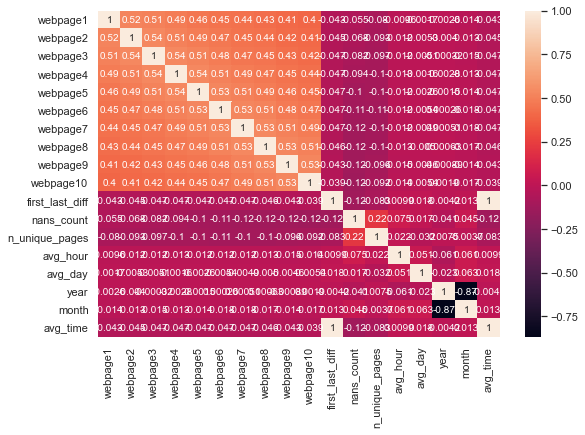

In [11]:
corr = data_train.corr()
sns.heatmap(corr, annot=True)

### Validation set

In [55]:
data_train2, data_valid, target_train, target_valid = train_test_split(data_train, data_target, stratify=data_target)

In [56]:
print(data_train2.shape)
print(data_valid.shape)

(119976, 18)
(39993, 18)


### Modeling

#### Cross validation

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

#### Random forest 

In [11]:
param_grid = {
    'max_depth': [5, 10, 15], # None;
    'max_features': [2, 3, 'auto'],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 6, 12],
    'n_estimators': [100, 300, 500]
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) 

rf = RandomForestClassifier(random_state=1)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = skf, n_jobs = -1, verbose = 2, scoring='roc_auc')

In [12]:
grid_search.fit(data_train, data_target)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': [2, 3, 'auto'],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 6, 12],
                         'n_estimators': [100, 300, 500]},
             scoring='roc_auc', verbose=2)

In [13]:
grid_search.best_params_

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 500}

In [11]:
rfc_test = RandomForestClassifier(random_state=1, max_depth=15, max_features='auto', min_samples_leaf=1,
                                 min_samples_split=6, n_estimators=500)
rfc_test.fit(data_train, data_target)

RandomForestClassifier(max_depth=15, min_samples_split=6, n_estimators=500,
                       random_state=1)

<AxesSubplot:>

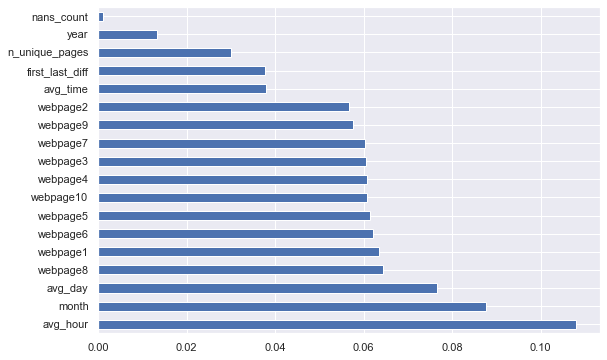

In [22]:
feat_importances = pd.Series(rfc_test.feature_importances_, index=data_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [23]:
rfc_test_2 = RandomForestClassifier(random_state=1, max_depth=None, max_features='auto', min_samples_leaf=1,
                                 min_samples_split=6, n_estimators=500)
rfc_test_2.fit(data_train, data_target)

RandomForestClassifier(min_samples_split=6, n_estimators=500, random_state=1)

#### dropping unimportant features

In [89]:
data_train_2 = data_train.drop(['nans_count'], axis=1)

In [90]:
data_test_2 = data_test.drop(['nans_count'], axis=1)

In [40]:
rfc_test_3 = RandomForestClassifier(random_state=1, max_depth=None, max_features='auto', min_samples_leaf=1,
                                 min_samples_split=6, n_estimators=500)
rfc_test_3.fit(data_train_2, data_target)

RandomForestClassifier(min_samples_split=6, n_estimators=500, random_state=1)

#### XGBoost

In [25]:
xg_clf = XGBClassifier(objective ='binary:logistic', random_state=42)

In [127]:
def objective(space):
    params = {
        'colsample_bytree': '{:.3f}'.format(space['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(space['learning_rate']),
        'alpha' : '{:.3f}'.format(space['alpha']),
        'n_estimators': space['n_estimators']
    }
    
    clf = XGBClassifier(
        objective ='binary:logistic',
        random_state=42,
        
        **params
    )
    
    score = cross_val_score(clf, data_train, data_target, scoring='roc_auc', cv=skf).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0, 1),
    'alpha': hp.uniform('alpha', 0, 10),
    'n_estimators': hp.choice('n_estimators', [100, 1000, 3000])
    }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

[08:27:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:27:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:27:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:28:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

AUC 0.992 params {'colsample_bytree': '0.977', 'learning_rate': '0.496', 'alpha': '9.470', 'n_estimators': 1000}       
[08:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:33:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_

AUC 0.989 params {'colsample_bytree': '0.589', 'learning_rate': '0.951', 'alpha': '2.913', 'n_estimators': 100}        
100%|██████████████████████████████████████████████| 10/10 [11:29<00:00, 68.91s/trial, best loss: 0.007202579059498171]


In [128]:
best_xg_clf = XGBClassifier(objective ='binary:logistic', 
                            alpha=best['alpha'],
                            colsample_bytree = best['colsample_bytree'],
                            learning_rate=best['learning_rate'],
                            n_estimators=best['n_estimators'],
                            random_state=42)

In [129]:
best_xg_clf.fit(data_train, data_target)

[08:40:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=5.8360686352409, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.4692835857970143, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5390533711039233, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=5.83606863, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

#### Catboost

In [90]:
clf = CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',
                         od_type = 'Iter',
                         verbose= False,
                        random_state=1)


In [91]:
search_spaces = {'iterations': Integer(10, 1000),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

In [93]:
opt = BayesSearchCV(clf, # not working in current sklearn version
                    search_spaces,
                    scoring='roc_auc',
                    cv=skf,
                    n_iter=10,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [12]:
space = dict()
space['iterations'] = randint(10, 1000)
space['depth'] = randint(1,8)
space['learning_rate'] = loguniform(0.01, 1)
space['random_strength'] = loguniform(1e-9, 10)
space['bagging_temperature'] = uniform(0,1)
space['border_count'] = randint(1,255)
space['l2_leaf_reg'] = randint(2,30)
space['scale_pos_weight'] = uniform(0.01,1)


In [107]:
opt = RandomizedSearchCV(clf,
                    space,
                    scoring='roc_auc',
                    cv=skf,
                    n_iter=10,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    refit=True,
                    random_state=1,
                    verbose=2)

In [108]:
%%time
opt.fit(data_train, data_target)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END bagging_temperature=0.417022004702574, border_count=141, depth=1, iterations=777, l2_leaf_reg=11, learning_rate=0.04024066464714609, random_strength=2.9346675384251166e-08, scale_pos_weight=0.1023385947687978; total time=  19.3s
[CV] END bagging_temperature=0.417022004702574, border_count=141, depth=1, iterations=777, l2_leaf_reg=11, learning_rate=0.04024066464714609, random_strength=2.9346675384251166e-08, scale_pos_weight=0.1023385947687978; total time=  18.9s
[CV] END bagging_temperature=0.417022004702574, border_count=141, depth=1, iterations=777, l2_leaf_reg=11, learning_rate=0.04024066464714609, random_strength=2.9346675384251166e-08, scale_pos_weight=0.1023385947687978; total time=  18.8s
[CV] END bagging_temperature=0.417022004702574, border_count=141, depth=1, iterations=777, l2_leaf_reg=11, learning_rate=0.04024066464714609, random_strength=2.9346675384251166e-08, scale_pos_weight=0.1023385947687978; total t

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000002CD83F37190>,
                   n_iter=3, n_jobs=1,
                   param_distributions={'bagging_temperature': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD84075E20>,
                                        'border_count': <scipy.stats._distn_infrastructure.rv_frozen object at 0...
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD84075C10>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD83F377C0>,
                                        'random_strength': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD84075670>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD84075A6

In [109]:
opt.best_params_

{'bagging_temperature': 0.20445224973151743,
 'border_count': 235,
 'depth': 5,
 'iterations': 935,
 'l2_leaf_reg': 16,
 'learning_rate': 0.2192476869880637,
 'random_strength': 1.4895257782642684e-05,
 'scale_pos_weight': 0.5686898284457517}

<AxesSubplot:>

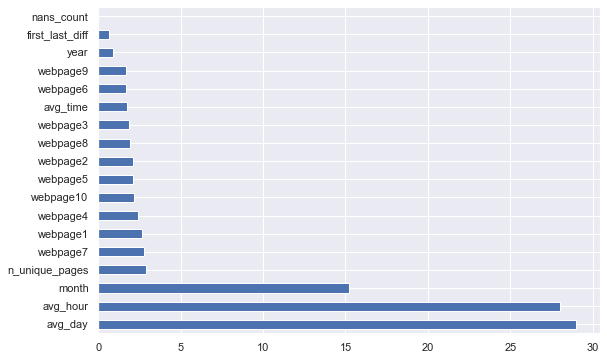

In [114]:
feat_importances = pd.Series(opt.best_estimator_.get_feature_importance(), index=data_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [117]:
opt_cat = RandomizedSearchCV(clf,
                    space,
                    scoring='roc_auc',
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    refit=True,
                    random_state=1,
                    verbose=2)

In [118]:
opt_cat.fit(data_train_2, data_target)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bagging_temperature=0.417022004702574, border_count=141, depth=1, iterations=777, l2_leaf_reg=11, learning_rate=0.04024066464714609, random_strength=2.9346675384251166e-08, scale_pos_weight=0.1023385947687978; total time=  18.2s
[CV] END bagging_temperature=0.417022004702574, border_count=141, depth=1, iterations=777, l2_leaf_reg=11, learning_rate=0.04024066464714609, random_strength=2.9346675384251166e-08, scale_pos_weight=0.1023385947687978; total time=  19.4s
[CV] END bagging_temperature=0.417022004702574, border_count=141, depth=1, iterations=777, l2_leaf_reg=11, learning_rate=0.04024066464714609, random_strength=2.9346675384251166e-08, scale_pos_weight=0.1023385947687978; total time=  18.3s
[CV] END bagging_temperature=0.417022004702574, border_count=141, depth=1, iterations=777, l2_leaf_reg=11, learning_rate=0.04024066464714609, random_strength=2.9346675384251166e-08, scale_pos_weight=0.1023385947687978; tota

[CV] END bagging_temperature=0.2804439920644052, border_count=216, depth=3, iterations=675, l2_leaf_reg=10, learning_rate=0.08679147174590263, random_strength=9.156354623529414e-09, scale_pos_weight=0.9133701664788674; total time=  28.5s
[CV] END bagging_temperature=0.2804439920644052, border_count=216, depth=3, iterations=675, l2_leaf_reg=10, learning_rate=0.08679147174590263, random_strength=9.156354623529414e-09, scale_pos_weight=0.9133701664788674; total time=  29.7s
[CV] END bagging_temperature=0.2804439920644052, border_count=216, depth=3, iterations=675, l2_leaf_reg=10, learning_rate=0.08679147174590263, random_strength=9.156354623529414e-09, scale_pos_weight=0.9133701664788674; total time=  28.6s
[CV] END bagging_temperature=0.2804439920644052, border_count=216, depth=3, iterations=675, l2_leaf_reg=10, learning_rate=0.08679147174590263, random_strength=9.156354623529414e-09, scale_pos_weight=0.9133701664788674; total time=  29.4s
[CV] END bagging_temperature=0.2804439920644052,

[CV] END bagging_temperature=0.8958862181960668, border_count=95, depth=5, iterations=499, l2_leaf_reg=26, learning_rate=0.21226725104456307, random_strength=0.0016479999800025995, scale_pos_weight=0.12474597295337518; total time=  26.9s
[CV] END bagging_temperature=0.8958862181960668, border_count=95, depth=5, iterations=499, l2_leaf_reg=26, learning_rate=0.21226725104456307, random_strength=0.0016479999800025995, scale_pos_weight=0.12474597295337518; total time=  26.4s
[CV] END bagging_temperature=0.8958862181960668, border_count=95, depth=5, iterations=499, l2_leaf_reg=26, learning_rate=0.21226725104456307, random_strength=0.0016479999800025995, scale_pos_weight=0.12474597295337518; total time=  26.7s
[CV] END bagging_temperature=0.8958862181960668, border_count=95, depth=5, iterations=499, l2_leaf_reg=26, learning_rate=0.21226725104456307, random_strength=0.0016479999800025995, scale_pos_weight=0.12474597295337518; total time=  26.0s
[CV] END bagging_temperature=0.8958862181960668,

[CV] END bagging_temperature=0.12417331511991114, border_count=235, depth=6, iterations=461, l2_leaf_reg=22, learning_rate=0.8693436708445293, random_strength=0.000407663841453748, scale_pos_weight=0.028647289372943023; total time=  26.1s
[CV] END bagging_temperature=0.12417331511991114, border_count=235, depth=6, iterations=461, l2_leaf_reg=22, learning_rate=0.8693436708445293, random_strength=0.000407663841453748, scale_pos_weight=0.028647289372943023; total time=  26.9s
[CV] END bagging_temperature=0.12417331511991114, border_count=235, depth=6, iterations=461, l2_leaf_reg=22, learning_rate=0.8693436708445293, random_strength=0.000407663841453748, scale_pos_weight=0.028647289372943023; total time=  26.5s
[CV] END bagging_temperature=0.12417331511991114, border_count=235, depth=6, iterations=461, l2_leaf_reg=22, learning_rate=0.8693436708445293, random_strength=0.000407663841453748, scale_pos_weight=0.028647289372943023; total time=  26.0s
[CV] END bagging_temperature=0.1241733151199

[CV] END bagging_temperature=0.5318264513359677, border_count=195, depth=1, iterations=748, l2_leaf_reg=19, learning_rate=0.12644347946825088, random_strength=0.028401698253586505, scale_pos_weight=0.6792328934531846; total time=  26.4s
[CV] END bagging_temperature=0.5318264513359677, border_count=195, depth=1, iterations=748, l2_leaf_reg=19, learning_rate=0.12644347946825088, random_strength=0.028401698253586505, scale_pos_weight=0.6792328934531846; total time=  26.1s
[CV] END bagging_temperature=0.5318264513359677, border_count=195, depth=1, iterations=748, l2_leaf_reg=19, learning_rate=0.12644347946825088, random_strength=0.028401698253586505, scale_pos_weight=0.6792328934531846; total time=  26.5s
[CV] END bagging_temperature=0.5318264513359677, border_count=195, depth=1, iterations=748, l2_leaf_reg=19, learning_rate=0.12644347946825088, random_strength=0.028401698253586505, scale_pos_weight=0.6792328934531846; total time=  26.3s
[CV] END bagging_temperature=0.5318264513359677, bor

[CV] END bagging_temperature=0.12632951943963733, border_count=44, depth=5, iterations=892, l2_leaf_reg=8, learning_rate=0.011042047487770415, random_strength=3.0178810093372, scale_pos_weight=0.8371154711707325; total time=  45.8s
[CV] END bagging_temperature=0.12632951943963733, border_count=44, depth=5, iterations=892, l2_leaf_reg=8, learning_rate=0.011042047487770415, random_strength=3.0178810093372, scale_pos_weight=0.8371154711707325; total time=  45.6s
[CV] END bagging_temperature=0.12632951943963733, border_count=44, depth=5, iterations=892, l2_leaf_reg=8, learning_rate=0.011042047487770415, random_strength=3.0178810093372, scale_pos_weight=0.8371154711707325; total time=  48.7s
[CV] END bagging_temperature=0.12632951943963733, border_count=44, depth=5, iterations=892, l2_leaf_reg=8, learning_rate=0.011042047487770415, random_strength=3.0178810093372, scale_pos_weight=0.8371154711707325; total time=  49.6s
[CV] END bagging_temperature=0.12632951943963733, border_count=44, depth

[CV] END bagging_temperature=0.20949288140767441, border_count=73, depth=5, iterations=652, l2_leaf_reg=5, learning_rate=0.2510545306286291, random_strength=0.009442673110849198, scale_pos_weight=0.08472389830882719; total time=  32.9s
[CV] END bagging_temperature=0.20949288140767441, border_count=73, depth=5, iterations=652, l2_leaf_reg=5, learning_rate=0.2510545306286291, random_strength=0.009442673110849198, scale_pos_weight=0.08472389830882719; total time=  32.1s
[CV] END bagging_temperature=0.20949288140767441, border_count=73, depth=5, iterations=652, l2_leaf_reg=5, learning_rate=0.2510545306286291, random_strength=0.009442673110849198, scale_pos_weight=0.08472389830882719; total time=  32.0s
[CV] END bagging_temperature=0.20949288140767441, border_count=73, depth=5, iterations=652, l2_leaf_reg=5, learning_rate=0.2510545306286291, random_strength=0.009442673110849198, scale_pos_weight=0.08472389830882719; total time=  25.5s
[CV] END bagging_temperature=0.20949288140767441, border

[CV] END bagging_temperature=0.2812168956686458, border_count=177, depth=7, iterations=417, l2_leaf_reg=4, learning_rate=0.20924919141556875, random_strength=7.4780056831344e-08, scale_pos_weight=0.5322865675902367; total time=  18.6s
[CV] END bagging_temperature=0.2812168956686458, border_count=177, depth=7, iterations=417, l2_leaf_reg=4, learning_rate=0.20924919141556875, random_strength=7.4780056831344e-08, scale_pos_weight=0.5322865675902367; total time=  19.0s
[CV] END bagging_temperature=0.2812168956686458, border_count=177, depth=7, iterations=417, l2_leaf_reg=4, learning_rate=0.20924919141556875, random_strength=7.4780056831344e-08, scale_pos_weight=0.5322865675902367; total time=  19.7s
[CV] END bagging_temperature=0.2812168956686458, border_count=177, depth=7, iterations=417, l2_leaf_reg=4, learning_rate=0.20924919141556875, random_strength=7.4780056831344e-08, scale_pos_weight=0.5322865675902367; total time=  20.1s
[CV] END bagging_temperature=0.2812168956686458, border_coun

[CV] END bagging_temperature=0.6251115937092561, border_count=211, depth=7, iterations=48, l2_leaf_reg=28, learning_rate=0.2797238561516252, random_strength=0.03913091599717574, scale_pos_weight=0.41630430578898825; total time=   1.6s
[CV] END bagging_temperature=0.6251115937092561, border_count=211, depth=7, iterations=48, l2_leaf_reg=28, learning_rate=0.2797238561516252, random_strength=0.03913091599717574, scale_pos_weight=0.41630430578898825; total time=   1.6s
[CV] END bagging_temperature=0.6251115937092561, border_count=211, depth=7, iterations=48, l2_leaf_reg=28, learning_rate=0.2797238561516252, random_strength=0.03913091599717574, scale_pos_weight=0.41630430578898825; total time=   1.5s
[CV] END bagging_temperature=0.6251115937092561, border_count=211, depth=7, iterations=48, l2_leaf_reg=28, learning_rate=0.2797238561516252, random_strength=0.03913091599717574, scale_pos_weight=0.41630430578898825; total time=   1.5s
[CV] END bagging_temperature=0.6251115937092561, border_coun

[CV] END bagging_temperature=0.26217308377291193, border_count=151, depth=6, iterations=485, l2_leaf_reg=11, learning_rate=0.5750507930861426, random_strength=4.550687388341053e-05, scale_pos_weight=0.7349801218405682; total time=  20.1s
[CV] END bagging_temperature=0.26217308377291193, border_count=151, depth=6, iterations=485, l2_leaf_reg=11, learning_rate=0.5750507930861426, random_strength=4.550687388341053e-05, scale_pos_weight=0.7349801218405682; total time=  20.2s
[CV] END bagging_temperature=0.26217308377291193, border_count=151, depth=6, iterations=485, l2_leaf_reg=11, learning_rate=0.5750507930861426, random_strength=4.550687388341053e-05, scale_pos_weight=0.7349801218405682; total time=  19.6s
[CV] END bagging_temperature=0.26217308377291193, border_count=151, depth=6, iterations=485, l2_leaf_reg=11, learning_rate=0.5750507930861426, random_strength=4.550687388341053e-05, scale_pos_weight=0.7349801218405682; total time=  20.7s
[CV] END bagging_temperature=0.26217308377291193

[CV] END bagging_temperature=0.3871354292850083, border_count=147, depth=2, iterations=661, l2_leaf_reg=13, learning_rate=0.1481514704424037, random_strength=0.005120591529617495, scale_pos_weight=0.09625654729577403; total time=  18.8s
[CV] END bagging_temperature=0.3871354292850083, border_count=147, depth=2, iterations=661, l2_leaf_reg=13, learning_rate=0.1481514704424037, random_strength=0.005120591529617495, scale_pos_weight=0.09625654729577403; total time=  18.5s
[CV] END bagging_temperature=0.3871354292850083, border_count=147, depth=2, iterations=661, l2_leaf_reg=13, learning_rate=0.1481514704424037, random_strength=0.005120591529617495, scale_pos_weight=0.09625654729577403; total time=  18.5s
[CV] END bagging_temperature=0.3871354292850083, border_count=147, depth=2, iterations=661, l2_leaf_reg=13, learning_rate=0.1481514704424037, random_strength=0.005120591529617495, scale_pos_weight=0.09625654729577403; total time=  19.2s
[CV] END bagging_temperature=0.3871354292850083, bor

[CV] END bagging_temperature=0.43359232727316455, border_count=63, depth=5, iterations=328, l2_leaf_reg=2, learning_rate=0.04084540693149833, random_strength=6.969723699740012e-05, scale_pos_weight=0.6600535832888426; total time=  11.8s
[CV] END bagging_temperature=0.43359232727316455, border_count=63, depth=5, iterations=328, l2_leaf_reg=2, learning_rate=0.04084540693149833, random_strength=6.969723699740012e-05, scale_pos_weight=0.6600535832888426; total time=  11.4s
[CV] END bagging_temperature=0.43359232727316455, border_count=63, depth=5, iterations=328, l2_leaf_reg=2, learning_rate=0.04084540693149833, random_strength=6.969723699740012e-05, scale_pos_weight=0.6600535832888426; total time=  11.5s
[CV] END bagging_temperature=0.43359232727316455, border_count=63, depth=5, iterations=328, l2_leaf_reg=2, learning_rate=0.04084540693149833, random_strength=6.969723699740012e-05, scale_pos_weight=0.6600535832888426; total time=  11.8s
[CV] END bagging_temperature=0.43359232727316455, bo

[CV] END bagging_temperature=0.7786384040043949, border_count=157, depth=5, iterations=588, l2_leaf_reg=12, learning_rate=0.718203717164916, random_strength=1.192995373446459e-08, scale_pos_weight=0.46264432277062995; total time=  20.7s
[CV] END bagging_temperature=0.7786384040043949, border_count=157, depth=5, iterations=588, l2_leaf_reg=12, learning_rate=0.718203717164916, random_strength=1.192995373446459e-08, scale_pos_weight=0.46264432277062995; total time=  20.5s
[CV] END bagging_temperature=0.7786384040043949, border_count=157, depth=5, iterations=588, l2_leaf_reg=12, learning_rate=0.718203717164916, random_strength=1.192995373446459e-08, scale_pos_weight=0.46264432277062995; total time=  20.9s
[CV] END bagging_temperature=0.7786384040043949, border_count=157, depth=5, iterations=588, l2_leaf_reg=12, learning_rate=0.718203717164916, random_strength=1.192995373446459e-08, scale_pos_weight=0.46264432277062995; total time=  20.6s
[CV] END bagging_temperature=0.7786384040043949, bor

[CV] END bagging_temperature=0.7701499563120922, border_count=150, depth=2, iterations=11, l2_leaf_reg=27, learning_rate=0.1091854188431799, random_strength=0.1258598200938822, scale_pos_weight=0.022603767029876314; total time=   0.2s
[CV] END bagging_temperature=0.7701499563120922, border_count=150, depth=2, iterations=11, l2_leaf_reg=27, learning_rate=0.1091854188431799, random_strength=0.1258598200938822, scale_pos_weight=0.022603767029876314; total time=   0.2s
[CV] END bagging_temperature=0.7701499563120922, border_count=150, depth=2, iterations=11, l2_leaf_reg=27, learning_rate=0.1091854188431799, random_strength=0.1258598200938822, scale_pos_weight=0.022603767029876314; total time=   0.2s
[CV] END bagging_temperature=0.7701499563120922, border_count=150, depth=2, iterations=11, l2_leaf_reg=27, learning_rate=0.1091854188431799, random_strength=0.1258598200938822, scale_pos_weight=0.022603767029876314; total time=   0.2s
[CV] END bagging_temperature=0.7701499563120922, border_coun

[CV] END bagging_temperature=0.6900753608385438, border_count=175, depth=2, iterations=21, l2_leaf_reg=10, learning_rate=0.15981175479884924, random_strength=0.003544960844854745, scale_pos_weight=0.5276940452596889; total time=   0.4s
[CV] END bagging_temperature=0.6900753608385438, border_count=175, depth=2, iterations=21, l2_leaf_reg=10, learning_rate=0.15981175479884924, random_strength=0.003544960844854745, scale_pos_weight=0.5276940452596889; total time=   0.4s
[CV] END bagging_temperature=0.6900753608385438, border_count=175, depth=2, iterations=21, l2_leaf_reg=10, learning_rate=0.15981175479884924, random_strength=0.003544960844854745, scale_pos_weight=0.5276940452596889; total time=   0.4s
[CV] END bagging_temperature=0.6900753608385438, border_count=175, depth=2, iterations=21, l2_leaf_reg=10, learning_rate=0.15981175479884924, random_strength=0.003544960844854745, scale_pos_weight=0.5276940452596889; total time=   0.4s
[CV] END bagging_temperature=0.6900753608385438, border_

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000002CD83F37190>,
                   n_iter=100, n_jobs=1,
                   param_distributions={'bagging_temperature': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD84075E20>,
                                        'border_count': <scipy.stats._distn_infrastructure.rv_frozen object a...
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD84075C10>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD83F377C0>,
                                        'random_strength': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD84075670>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD84075A60

In [119]:
opt_cat.best_params_

{'bagging_temperature': 0.9248079703993507,
 'border_count': 221,
 'depth': 4,
 'iterations': 889,
 'l2_leaf_reg': 12,
 'learning_rate': 0.2952105858077268,
 'random_strength': 0.05269632093728587,
 'scale_pos_weight': 0.917815852503524}

#### Lightgbm

In [99]:
lgb_clf = LGBMClassifier(objective='binary', num_threads=2)

In [133]:
space = dict()
space['num_trees'] = randint(500,1500)
space['num_leaves'] = randint(5,40)
space['learning_rate'] = loguniform(0.01, 1)
space['boosting'] = ['gbdt', 'rf', 'dart', 'goss']
space['tree_learner'] = ['serial', 'feature', 'data', 'voting']

In [134]:
lgbm = RandomizedSearchCV(lgb_clf,
                    space,
                    scoring='roc_auc',
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    refit=True,
                    random_state=1,
                    verbose=2)

In [135]:
lgbm.fit(data_train, data_target)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1267, num_trees=1267 will be ignored. Current value: num_iterations=1267
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   1.6s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.5s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.4s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.5s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=featur

[CV] END boosting=gbdt, learning_rate=0.570472708820368, num_leaves=34, num_trees=898, tree_learner=data; total time=  12.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=898, num_trees=898 will be ignored. Current value: num_iterations=898
[CV] END boosting=gbdt, learning_rate=0.570472708820368, num_leaves=34, num_trees=898, tree_learner=data; total time=  12.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=898, num_trees=898 will be ignored. Current value: num_iterations=898
[CV] END boosting=gbdt, learning_rate=0.570472708820368, num_leaves=34, num_trees=898, tree_learner=data; tota

[CV] END boosting=gbdt, learning_rate=0.45625403553769195, num_leaves=13, num_trees=1042, tree_learner=voting; total time=  10.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1464, num_trees=1464 will be ignored. Current value: num_iterations=1464
[CV] END boosting=goss, learning_rate=0.22044903133055474, num_leaves=8, num_trees=1464, tree_learner=serial; total time=  15.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1464, num_trees=1464 will be ignored. Current value: num_iterations=1464
[CV] END boosting=goss, learning_rate=0.22044903133055474, num_leaves=8, num_trees=1464, tree_l

[CV] END boosting=goss, learning_rate=0.6408263084683605, num_leaves=32, num_trees=1433, tree_learner=feature; total time=  14.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1433, num_trees=1433 will be ignored. Current value: num_iterations=1433
[CV] END boosting=goss, learning_rate=0.6408263084683605, num_leaves=32, num_trees=1433, tree_learner=feature; total time=  14.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1433, num_trees=1433 will be ignored. Current value: num_iterations=1433
[CV] END boosting=goss, learning_rate=0.6408263084683605, num_leaves=32, num_trees=1433, tree_

[CV] END boosting=goss, learning_rate=0.8185991952096643, num_leaves=37, num_trees=1228, tree_learner=voting; total time=  12.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1271, num_trees=1271 will be ignored. Current value: num_iterations=1271
[CV] END boosting=goss, learning_rate=0.7941019766733355, num_leaves=18, num_trees=1271, tree_learner=serial; total time=  12.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1271, num_trees=1271 will be ignored. Current value: num_iterations=1271
[CV] END boosting=goss, learning_rate=0.7941019766733355, num_leaves=18, num_trees=1271, tree_le

[CV] END boosting=goss, learning_rate=0.1206636280191546, num_leaves=16, num_trees=832, tree_learner=voting; total time=   7.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=832, num_trees=832 will be ignored. Current value: num_iterations=832
[CV] END boosting=goss, learning_rate=0.1206636280191546, num_leaves=16, num_trees=832, tree_learner=voting; total time=   8.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1313, num_trees=1313 will be ignored. Current value: num_iterations=1313
[CV] END boosting=gbdt, learning_rate=0.05690739192818569, num_leaves=12, num_trees=1313, tree_learne

[CV] END boosting=rf, learning_rate=0.07180957886080991, num_leaves=29, num_trees=838, tree_learner=voting; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.07180957886080991, num_leaves=29, num_trees=838, tree_learner=voting; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.07180957886080991, num_leaves=29, num_trees=838, tree_learner=voting; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.07180957886080991, num_leaves=29, num_trees=838, tree_learner=voting; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.07180957886080991, num_leaves=29, num_trees=838, tree_learner=voting; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.014047014243829021, num_leaves=33, num_trees=1115, tree_learner=data; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.014047014243829021, num_leaves=33, num_trees=1115, tree_learner=data; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.014047014243829021, num_leaves=33, num_trees=1115, tree_learner=data; tot

[CV] END boosting=rf, learning_rate=0.08735376243510473, num_leaves=25, num_trees=510, tree_learner=serial; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.08735376243510473, num_leaves=25, num_trees=510, tree_learner=serial; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.08735376243510473, num_leaves=25, num_trees=510, tree_learner=serial; total time=   0.2s
[CV] END boosting=goss, learning_rate=0.7225609176928368, num_leaves=30, num_trees=905, tree_learner=voting; total time=   9.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=905, num_trees=905 will be ignored. Current value: num_iterations=905
[CV] END boosting=goss, learning_rate=0.7225609176928368, num_leaves=30, num_trees=905, tree_learner=voting; total time=   8.4s
[LightGBM] [Warning] boosting is set=goss, 

[CV] END boosting=rf, learning_rate=0.010958731027416018, num_leaves=26, num_trees=796, tree_learner=feature; total time=   0.1s
[CV] END boosting=goss, learning_rate=0.5248750117470283, num_leaves=18, num_trees=924, tree_learner=data; total time=   9.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=924, num_trees=924 will be ignored. Current value: num_iterations=924
[CV] END boosting=goss, learning_rate=0.5248750117470283, num_leaves=18, num_trees=924, tree_learner=data; total time=   9.9s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=924, num_trees=924 will be ignored. Current value

[CV] END boosting=goss, learning_rate=0.018746079363320116, num_leaves=33, num_trees=722, tree_learner=data; total time=   9.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=722, num_trees=722 will be ignored. Current value: num_iterations=722
[CV] END boosting=goss, learning_rate=0.018746079363320116, num_leaves=33, num_trees=722, tree_learner=data; total time=   8.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=722, num_trees=722 will be ignored. Current value: num_iterations=722
[CV] END boosting=goss, learning_rate=0.018746079363320116, num_leaves=33, num_trees=722, tree_learner=d

[CV] END boosting=dart, learning_rate=0.014058467687542332, num_leaves=24, num_trees=751, tree_learner=data; total time=  53.1s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=751, num_trees=751 will be ignored. Current value: num_iterations=751
[CV] END boosting=dart, learning_rate=0.014058467687542332, num_leaves=24, num_trees=751, tree_learner=data; total time=  57.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=600, num_trees=600 will be ignored. Current value: num_iterations=600
[CV] END boosting=goss, learning_rate=0.1454513828418547, num_leaves=39, num_trees=600, tree_learner=ser

[CV] END boosting=dart, learning_rate=0.05758141662606777, num_leaves=9, num_trees=1332, tree_learner=serial; total time= 1.7min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1332, num_trees=1332 will be ignored. Current value: num_iterations=1332
[CV] END boosting=dart, learning_rate=0.05758141662606777, num_leaves=9, num_trees=1332, tree_learner=serial; total time= 1.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1332, num_trees=1332 will be ignored. Current value: num_iterations=1332
[CV] END boosting=dart, learning_rate=0.05758141662606777, num_leaves=9, num_trees=1332, tree_le

[CV] END boosting=dart, learning_rate=0.013585416662798935, num_leaves=5, num_trees=842, tree_learner=voting; total time=  24.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=551, num_trees=551 will be ignored. Current value: num_iterations=551
[CV] END boosting=gbdt, learning_rate=0.47784872068588213, num_leaves=33, num_trees=551, tree_learner=voting; total time=   5.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=551, num_trees=551 will be ignored. Current value: num_iterations=551
[CV] END boosting=gbdt, learning_rate=0.47784872068588213, num_leaves=33, num_trees=551, tree_learner=

[CV] END boosting=dart, learning_rate=0.1298094698960756, num_leaves=30, num_trees=1321, tree_learner=serial; total time= 3.0min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1321, num_trees=1321 will be ignored. Current value: num_iterations=1321
[CV] END boosting=dart, learning_rate=0.1298094698960756, num_leaves=30, num_trees=1321, tree_learner=serial; total time= 2.9min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1321, num_trees=1321 will be ignored. Current value: num_iterations=1321
[CV] END boosting=dart, learning_rate=0.1298094698960756, num_leaves=30, num_trees=1321, tree_le

[CV] END boosting=rf, learning_rate=0.1014265871164267, num_leaves=32, num_trees=543, tree_learner=feature; total time=   0.1s
[CV] END boosting=rf, learning_rate=0.1014265871164267, num_leaves=32, num_trees=543, tree_learner=feature; total time=   0.1s
[CV] END boosting=rf, learning_rate=0.1014265871164267, num_leaves=32, num_trees=543, tree_learner=feature; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.1014265871164267, num_leaves=32, num_trees=543, tree_learner=feature; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.1014265871164267, num_leaves=32, num_trees=543, tree_learner=feature; total time=   0.1s
[CV] END boosting=dart, learning_rate=0.03655556753655348, num_leaves=37, num_trees=910, tree_learner=serial; total time= 1.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iter

[CV] END boosting=dart, learning_rate=0.07368052267166847, num_leaves=36, num_trees=1065, tree_learner=feature; total time= 2.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1065, num_trees=1065 will be ignored. Current value: num_iterations=1065
[CV] END boosting=dart, learning_rate=0.07368052267166847, num_leaves=36, num_trees=1065, tree_learner=feature; total time= 2.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1065, num_trees=1065 will be ignored. Current value: num_iterations=1065
[CV] END boosting=dart, learning_rate=0.07368052267166847, num_leaves=36, num_trees=1065, tr

[CV] END boosting=gbdt, learning_rate=0.049588393215035484, num_leaves=18, num_trees=925, tree_learner=feature; total time=  11.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=925, num_trees=925 will be ignored. Current value: num_iterations=925
[CV] END boosting=gbdt, learning_rate=0.049588393215035484, num_leaves=18, num_trees=925, tree_learner=feature; total time=  14.0s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=925, num_trees=925 will be ignored. Current value: num_iterations=925
[CV] END boosting=gbdt, learning_rate=0.049588393215035484, num_leaves=18, num_trees=925, tree_lea

[CV] END boosting=goss, learning_rate=0.06352711998307646, num_leaves=31, num_trees=732, tree_learner=feature; total time=   7.5s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=732, num_trees=732 will be ignored. Current value: num_iterations=732
[CV] END boosting=goss, learning_rate=0.06352711998307646, num_leaves=31, num_trees=732, tree_learner=feature; total time=   7.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=732, num_trees=732 will be ignored. Current value: num_iterations=732
[CV] END boosting=goss, learning_rate=0.06352711998307646, num_leaves=31, num_trees=732, tree_learne

[CV] END boosting=goss, learning_rate=0.21156295517755347, num_leaves=32, num_trees=1189, tree_learner=data; total time=  14.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1189, num_trees=1189 will be ignored. Current value: num_iterations=1189
[CV] END boosting=goss, learning_rate=0.21156295517755347, num_leaves=32, num_trees=1189, tree_learner=data; total time=  13.8s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=954, num_trees=954 will be ignored. Current value: num_iterations=954
[CV] END boosting=dart, learning_rate=0.12062548866367542, num_leaves=38, num_trees=954, tree_learner

[CV] END boosting=goss, learning_rate=0.2578483005848497, num_leaves=19, num_trees=860, tree_learner=data; total time=   8.9s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=860, num_trees=860 will be ignored. Current value: num_iterations=860
[CV] END boosting=goss, learning_rate=0.2578483005848497, num_leaves=19, num_trees=860, tree_learner=data; total time=   8.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=860, num_trees=860 will be ignored. Current value: num_iterations=860
[CV] END boosting=goss, learning_rate=0.2578483005848497, num_leaves=19, num_trees=860, tree_learner=data; t

[CV] END boosting=gbdt, learning_rate=0.02737573585687714, num_leaves=22, num_trees=1406, tree_learner=serial; total time=  11.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1406, num_trees=1406 will be ignored. Current value: num_iterations=1406
[CV] END boosting=gbdt, learning_rate=0.02737573585687714, num_leaves=22, num_trees=1406, tree_learner=serial; total time=  10.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=653, num_trees=653 will be ignored. Current value: num_iterations=653
[CV] END boosting=gbdt, learning_rate=0.01041898357212113, num_leaves=17, num_trees=653, tree_lea

[CV] END boosting=gbdt, learning_rate=0.020199624126149344, num_leaves=15, num_trees=1408, tree_learner=data; total time=   9.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1408, num_trees=1408 will be ignored. Current value: num_iterations=1408
[CV] END boosting=gbdt, learning_rate=0.020199624126149344, num_leaves=15, num_trees=1408, tree_learner=data; total time=  10.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1408, num_trees=1408 will be ignored. Current value: num_iterations=1408
[CV] END boosting=gbdt, learning_rate=0.020199624126149344, num_leaves=15, num_trees=1408, tree_

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=LGBMClassifier(num_threads=2, objective='binary',
                                            random_state=1),
                   n_iter=100, n_jobs=1,
                   param_distributions={'boosting': ['gbdt', 'rf', 'dart',
                                                     'goss'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CDEAB3EFA0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD8100F670>,
                                        'num_trees': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD815DD2B0>,
                                        'tree_learner': ['serial', 'feature',
                                                         'data', 'voting']},
                   random_state=1, scoring='roc_auc', 

In [136]:
lgbm.best_params_

{'boosting': 'dart',
 'learning_rate': 0.07368052267166847,
 'num_leaves': 36,
 'num_trees': 1065,
 'tree_learner': 'feature'}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

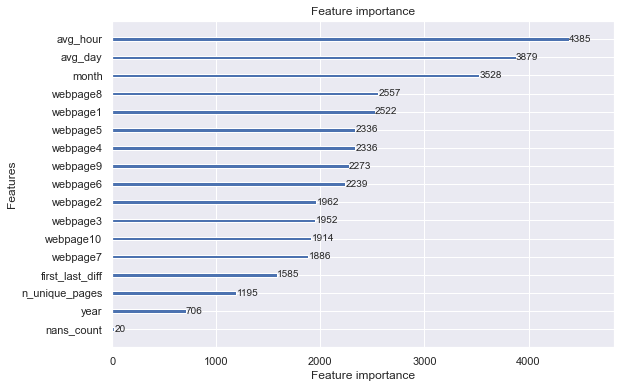

In [143]:
plot_importance(lgbm.best_estimator_)

In [144]:
lgbm_2 = LGBMClassifier(objective='binary', random_state=1, num_threads=2, boosting= 'dart',
 learning_rate = 0.07368052267166847,
 num_leaves = 36,
  num_trees =  1065,
 tree_learner = 'feature')

In [145]:
lgbm_2.fit(data_train_2, data_target)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1065, num_trees=1065 will be ignored. Current value: num_iterations=1065


LGBMClassifier(boosting='dart', learning_rate=0.07368052267166847,
               num_leaves=36, num_threads=2, num_trees=1065, objective='binary',
               random_state=1, tree_learner='feature')

In [148]:
lgbm_3 = RandomizedSearchCV(lgb_clf,
                    space,
                    scoring='roc_auc',
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    refit=True,
                    random_state=1,
                    verbose=2)

In [149]:
lgbm_3.fit(data_train_2, data_target)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1267, num_trees=1267 will be ignored. Current value: num_iterations=1267
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.1s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=feature; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.9871192514273244, num_leaves=13, num_trees=1267, tree_learner=featur

[CV] END boosting=gbdt, learning_rate=0.570472708820368, num_leaves=34, num_trees=898, tree_learner=data; total time=   8.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=898, num_trees=898 will be ignored. Current value: num_iterations=898
[CV] END boosting=gbdt, learning_rate=0.570472708820368, num_leaves=34, num_trees=898, tree_learner=data; total time=   9.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=898, num_trees=898 will be ignored. Current value: num_iterations=898
[CV] END boosting=gbdt, learning_rate=0.570472708820368, num_leaves=34, num_trees=898, tree_learner=data; tota

[CV] END boosting=gbdt, learning_rate=0.45625403553769195, num_leaves=13, num_trees=1042, tree_learner=voting; total time=   8.9s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1464, num_trees=1464 will be ignored. Current value: num_iterations=1464
[CV] END boosting=goss, learning_rate=0.22044903133055474, num_leaves=8, num_trees=1464, tree_learner=serial; total time=  16.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1464, num_trees=1464 will be ignored. Current value: num_iterations=1464
[CV] END boosting=goss, learning_rate=0.22044903133055474, num_leaves=8, num_trees=1464, tree_l

[CV] END boosting=goss, learning_rate=0.6408263084683605, num_leaves=32, num_trees=1433, tree_learner=feature; total time=  14.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1433, num_trees=1433 will be ignored. Current value: num_iterations=1433
[CV] END boosting=goss, learning_rate=0.6408263084683605, num_leaves=32, num_trees=1433, tree_learner=feature; total time=  14.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1433, num_trees=1433 will be ignored. Current value: num_iterations=1433
[CV] END boosting=goss, learning_rate=0.6408263084683605, num_leaves=32, num_trees=1433, tree_

[CV] END boosting=goss, learning_rate=0.8185991952096643, num_leaves=37, num_trees=1228, tree_learner=voting; total time=  13.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1271, num_trees=1271 will be ignored. Current value: num_iterations=1271
[CV] END boosting=goss, learning_rate=0.7941019766733355, num_leaves=18, num_trees=1271, tree_learner=serial; total time=  12.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1271, num_trees=1271 will be ignored. Current value: num_iterations=1271
[CV] END boosting=goss, learning_rate=0.7941019766733355, num_leaves=18, num_trees=1271, tree_le

[CV] END boosting=goss, learning_rate=0.1206636280191546, num_leaves=16, num_trees=832, tree_learner=voting; total time=   8.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=832, num_trees=832 will be ignored. Current value: num_iterations=832
[CV] END boosting=goss, learning_rate=0.1206636280191546, num_leaves=16, num_trees=832, tree_learner=voting; total time=   8.9s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1313, num_trees=1313 will be ignored. Current value: num_iterations=1313
[CV] END boosting=gbdt, learning_rate=0.05690739192818569, num_leaves=12, num_trees=1313, tree_learne

[CV] END boosting=rf, learning_rate=0.07180957886080991, num_leaves=29, num_trees=838, tree_learner=voting; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.07180957886080991, num_leaves=29, num_trees=838, tree_learner=voting; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.07180957886080991, num_leaves=29, num_trees=838, tree_learner=voting; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.07180957886080991, num_leaves=29, num_trees=838, tree_learner=voting; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.07180957886080991, num_leaves=29, num_trees=838, tree_learner=voting; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.014047014243829021, num_leaves=33, num_trees=1115, tree_learner=data; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.014047014243829021, num_leaves=33, num_trees=1115, tree_learner=data; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.014047014243829021, num_leaves=33, num_trees=1115, tree_learner=data; tot

[CV] END boosting=rf, learning_rate=0.08735376243510473, num_leaves=25, num_trees=510, tree_learner=serial; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.08735376243510473, num_leaves=25, num_trees=510, tree_learner=serial; total time=   0.1s
[CV] END boosting=rf, learning_rate=0.08735376243510473, num_leaves=25, num_trees=510, tree_learner=serial; total time=   0.2s
[CV] END boosting=goss, learning_rate=0.7225609176928368, num_leaves=30, num_trees=905, tree_learner=voting; total time=   8.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=905, num_trees=905 will be ignored. Current value: num_iterations=905
[CV] END boosting=goss, learning_rate=0.7225609176928368, num_leaves=30, num_trees=905, tree_learner=voting; total time=   9.2s
[LightGBM] [Warning] boosting is set=goss, 

[CV] END boosting=rf, learning_rate=0.010958731027416018, num_leaves=26, num_trees=796, tree_learner=feature; total time=   0.2s
[CV] END boosting=goss, learning_rate=0.5248750117470283, num_leaves=18, num_trees=924, tree_learner=data; total time=   9.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=924, num_trees=924 will be ignored. Current value: num_iterations=924
[CV] END boosting=goss, learning_rate=0.5248750117470283, num_leaves=18, num_trees=924, tree_learner=data; total time=   9.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=924, num_trees=924 will be ignored. Current value

[CV] END boosting=goss, learning_rate=0.018746079363320116, num_leaves=33, num_trees=722, tree_learner=data; total time=   9.8s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=722, num_trees=722 will be ignored. Current value: num_iterations=722
[CV] END boosting=goss, learning_rate=0.018746079363320116, num_leaves=33, num_trees=722, tree_learner=data; total time=   9.0s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=722, num_trees=722 will be ignored. Current value: num_iterations=722
[CV] END boosting=goss, learning_rate=0.018746079363320116, num_leaves=33, num_trees=722, tree_learner=d

[CV] END boosting=dart, learning_rate=0.014058467687542332, num_leaves=24, num_trees=751, tree_learner=data; total time=  52.7s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=751, num_trees=751 will be ignored. Current value: num_iterations=751
[CV] END boosting=dart, learning_rate=0.014058467687542332, num_leaves=24, num_trees=751, tree_learner=data; total time=  55.6s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=600, num_trees=600 will be ignored. Current value: num_iterations=600
[CV] END boosting=goss, learning_rate=0.1454513828418547, num_leaves=39, num_trees=600, tree_learner=ser

[CV] END boosting=dart, learning_rate=0.05758141662606777, num_leaves=9, num_trees=1332, tree_learner=serial; total time= 2.0min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1332, num_trees=1332 will be ignored. Current value: num_iterations=1332
[CV] END boosting=dart, learning_rate=0.05758141662606777, num_leaves=9, num_trees=1332, tree_learner=serial; total time= 2.1min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1332, num_trees=1332 will be ignored. Current value: num_iterations=1332
[CV] END boosting=dart, learning_rate=0.05758141662606777, num_leaves=9, num_trees=1332, tree_le

[CV] END boosting=dart, learning_rate=0.013585416662798935, num_leaves=5, num_trees=842, tree_learner=voting; total time=  23.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=551, num_trees=551 will be ignored. Current value: num_iterations=551
[CV] END boosting=gbdt, learning_rate=0.47784872068588213, num_leaves=33, num_trees=551, tree_learner=voting; total time=   5.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=551, num_trees=551 will be ignored. Current value: num_iterations=551
[CV] END boosting=gbdt, learning_rate=0.47784872068588213, num_leaves=33, num_trees=551, tree_learner=

[CV] END boosting=dart, learning_rate=0.1298094698960756, num_leaves=30, num_trees=1321, tree_learner=serial; total time= 3.0min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1321, num_trees=1321 will be ignored. Current value: num_iterations=1321
[CV] END boosting=dart, learning_rate=0.1298094698960756, num_leaves=30, num_trees=1321, tree_learner=serial; total time= 3.1min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1321, num_trees=1321 will be ignored. Current value: num_iterations=1321
[CV] END boosting=dart, learning_rate=0.1298094698960756, num_leaves=30, num_trees=1321, tree_le

[CV] END boosting=rf, learning_rate=0.1014265871164267, num_leaves=32, num_trees=543, tree_learner=feature; total time=   0.1s
[CV] END boosting=rf, learning_rate=0.1014265871164267, num_leaves=32, num_trees=543, tree_learner=feature; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.1014265871164267, num_leaves=32, num_trees=543, tree_learner=feature; total time=   0.2s
[CV] END boosting=rf, learning_rate=0.1014265871164267, num_leaves=32, num_trees=543, tree_learner=feature; total time=   0.1s
[CV] END boosting=rf, learning_rate=0.1014265871164267, num_leaves=32, num_trees=543, tree_learner=feature; total time=   0.1s
[CV] END boosting=dart, learning_rate=0.03655556753655348, num_leaves=37, num_trees=910, tree_learner=serial; total time= 1.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iter

[CV] END boosting=dart, learning_rate=0.07368052267166847, num_leaves=36, num_trees=1065, tree_learner=feature; total time= 3.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1065, num_trees=1065 will be ignored. Current value: num_iterations=1065
[CV] END boosting=dart, learning_rate=0.07368052267166847, num_leaves=36, num_trees=1065, tree_learner=feature; total time= 3.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1065, num_trees=1065 will be ignored. Current value: num_iterations=1065
[CV] END boosting=dart, learning_rate=0.07368052267166847, num_leaves=36, num_trees=1065, tr

[CV] END boosting=gbdt, learning_rate=0.049588393215035484, num_leaves=18, num_trees=925, tree_learner=feature; total time=  11.2s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=925, num_trees=925 will be ignored. Current value: num_iterations=925
[CV] END boosting=gbdt, learning_rate=0.049588393215035484, num_leaves=18, num_trees=925, tree_learner=feature; total time=  10.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=925, num_trees=925 will be ignored. Current value: num_iterations=925
[CV] END boosting=gbdt, learning_rate=0.049588393215035484, num_leaves=18, num_trees=925, tree_lea

[CV] END boosting=goss, learning_rate=0.06352711998307646, num_leaves=31, num_trees=732, tree_learner=feature; total time=  10.7s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=732, num_trees=732 will be ignored. Current value: num_iterations=732
[CV] END boosting=goss, learning_rate=0.06352711998307646, num_leaves=31, num_trees=732, tree_learner=feature; total time=  10.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=732, num_trees=732 will be ignored. Current value: num_iterations=732
[CV] END boosting=goss, learning_rate=0.06352711998307646, num_leaves=31, num_trees=732, tree_learne

[CV] END boosting=goss, learning_rate=0.21156295517755347, num_leaves=32, num_trees=1189, tree_learner=data; total time=  18.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1189, num_trees=1189 will be ignored. Current value: num_iterations=1189
[CV] END boosting=goss, learning_rate=0.21156295517755347, num_leaves=32, num_trees=1189, tree_learner=data; total time=  17.5s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=954, num_trees=954 will be ignored. Current value: num_iterations=954
[CV] END boosting=dart, learning_rate=0.12062548866367542, num_leaves=38, num_trees=954, tree_learner

[CV] END boosting=goss, learning_rate=0.2578483005848497, num_leaves=19, num_trees=860, tree_learner=data; total time=  16.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=860, num_trees=860 will be ignored. Current value: num_iterations=860
[CV] END boosting=goss, learning_rate=0.2578483005848497, num_leaves=19, num_trees=860, tree_learner=data; total time=  16.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=860, num_trees=860 will be ignored. Current value: num_iterations=860
[CV] END boosting=goss, learning_rate=0.2578483005848497, num_leaves=19, num_trees=860, tree_learner=data; t

[CV] END boosting=gbdt, learning_rate=0.02737573585687714, num_leaves=22, num_trees=1406, tree_learner=serial; total time=  22.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1406, num_trees=1406 will be ignored. Current value: num_iterations=1406
[CV] END boosting=gbdt, learning_rate=0.02737573585687714, num_leaves=22, num_trees=1406, tree_learner=serial; total time=  22.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=653, num_trees=653 will be ignored. Current value: num_iterations=653
[CV] END boosting=gbdt, learning_rate=0.01041898357212113, num_leaves=17, num_trees=653, tree_lea

[CV] END boosting=gbdt, learning_rate=0.020199624126149344, num_leaves=15, num_trees=1408, tree_learner=data; total time=  15.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1408, num_trees=1408 will be ignored. Current value: num_iterations=1408
[CV] END boosting=gbdt, learning_rate=0.020199624126149344, num_leaves=15, num_trees=1408, tree_learner=data; total time=  14.9s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1408, num_trees=1408 will be ignored. Current value: num_iterations=1408
[CV] END boosting=gbdt, learning_rate=0.020199624126149344, num_leaves=15, num_trees=1408, tree_

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=LGBMClassifier(num_threads=2, objective='binary',
                                            random_state=1),
                   n_iter=100, n_jobs=1,
                   param_distributions={'boosting': ['gbdt', 'rf', 'dart',
                                                     'goss'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CDEAB3EFA0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD8100F670>,
                                        'num_trees': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002CD815DD2B0>,
                                        'tree_learner': ['serial', 'feature',
                                                         'data', 'voting']},
                   random_state=1, scoring='roc_auc', 

In [150]:
lgbm_3.best_params_

{'boosting': 'dart',
 'learning_rate': 0.07368052267166847,
 'num_leaves': 36,
 'num_trees': 1065,
 'tree_learner': 'feature'}

In [13]:
space = dict()
space['num_trees'] = randint(1000,1250)
space['num_leaves'] = randint(30,45)
space['learning_rate'] = loguniform(0.01, 0.2)
space['boosting'] = ['dart']
space['tree_learner'] = ['feature']

In [14]:
lgbm_4 = RandomizedSearchCV(lgb_clf,
                    space,
                    scoring='roc_auc',
                    cv=skf,
                    n_iter=20,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    refit=True,
                    random_state=123,
                    verbose=2)

In [15]:
lgbm_4.fit(data_train, data_target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1066, num_trees=1066 will be ignored. Current value: num_iterations=1066
[CV] END boosting=dart, learning_rate=0.08056145504074186, num_leaves=44, num_trees=1066, tree_learner=feature; total time= 2.5min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1066, num_trees=1066 will be ignored. Current value: num_iterations=1066
[CV] END boosting=dart, learning_rate=0.08056145504074186, num_leaves=44, num_trees=1066, tree_learner=feature; total time= 2.5min
[LightGBM] [Warning] boosting 

[CV] END boosting=dart, learning_rate=0.18880071765466017, num_leaves=30, num_trees=1113, tree_learner=feature; total time= 1.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1113, num_trees=1113 will be ignored. Current value: num_iterations=1113
[CV] END boosting=dart, learning_rate=0.18880071765466017, num_leaves=30, num_trees=1113, tree_learner=feature; total time= 1.8min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1032, num_trees=1032 will be ignored. Current value: num_iterations=1032
[CV] END boosting=dart, learning_rate=0.04223833882869233, num_leaves=39, num_trees=1032, tr

[CV] END boosting=dart, learning_rate=0.05924952001908294, num_leaves=31, num_trees=1055, tree_learner=feature; total time= 2.1min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1055, num_trees=1055 will be ignored. Current value: num_iterations=1055
[CV] END boosting=dart, learning_rate=0.05924952001908294, num_leaves=31, num_trees=1055, tree_learner=feature; total time= 2.2min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1055, num_trees=1055 will be ignored. Current value: num_iterations=1055
[CV] END boosting=dart, learning_rate=0.05924952001908294, num_leaves=31, num_trees=1055, tr

[CV] END boosting=dart, learning_rate=0.062367726860315824, num_leaves=34, num_trees=1102, tree_learner=feature; total time= 3.3min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1102, num_trees=1102 will be ignored. Current value: num_iterations=1102
[CV] END boosting=dart, learning_rate=0.062367726860315824, num_leaves=34, num_trees=1102, tree_learner=feature; total time= 3.0min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1102, num_trees=1102 will be ignored. Current value: num_iterations=1102
[CV] END boosting=dart, learning_rate=0.062367726860315824, num_leaves=34, num_trees=1102,

[CV] END boosting=dart, learning_rate=0.03666555260153886, num_leaves=32, num_trees=1058, tree_learner=feature; total time= 2.3min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1058, num_trees=1058 will be ignored. Current value: num_iterations=1058
[CV] END boosting=dart, learning_rate=0.03666555260153886, num_leaves=32, num_trees=1058, tree_learner=feature; total time= 2.3min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1058, num_trees=1058 will be ignored. Current value: num_iterations=1058
[CV] END boosting=dart, learning_rate=0.03666555260153886, num_leaves=32, num_trees=1058, tr

[CV] END boosting=dart, learning_rate=0.14532023751620635, num_leaves=44, num_trees=1180, tree_learner=feature; total time= 2.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1154, num_trees=1154 will be ignored. Current value: num_iterations=1154
[CV] END boosting=dart, learning_rate=0.044968103124964305, num_leaves=33, num_trees=1154, tree_learner=feature; total time= 2.3min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1154, num_trees=1154 will be ignored. Current value: num_iterations=1154
[CV] END boosting=dart, learning_rate=0.044968103124964305, num_leaves=33, num_trees=1154, 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=LGBMClassifier(num_threads=2, objective='binary'),
                   n_iter=20, n_jobs=1,
                   param_distributions={'boosting': ['dart'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F8625C4D00>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F87ECA5E50>,
                                        'num_trees': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F87ECA5BE0>,
                                        'tree_learner': ['feature']},
                   random_state=123, scoring='roc_auc', verbose=2)

In [16]:
lgbm_4.best_params_

{'boosting': 'dart',
 'learning_rate': 0.06620927978015646,
 'num_leaves': 40,
 'num_trees': 1069,
 'tree_learner': 'feature'}

In [18]:
lgbm_5 = LGBMClassifier(objective='binary', random_state=1, num_threads=2, boosting= 'dart',
 learning_rate = 0.08,
 num_leaves = 36,
  num_trees =  1065,
 tree_learner = 'feature')

In [19]:
lgbm_5.fit(data_train, data_target)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1065, num_trees=1065 will be ignored. Current value: num_iterations=1065


LGBMClassifier(boosting='dart', learning_rate=0.08, num_leaves=36,
               num_threads=2, num_trees=1065, objective='binary',
               random_state=1, tree_learner='feature')

In [21]:
lgbm_6 = LGBMClassifier(objective='binary', random_state=1, num_threads=2, boosting= 'dart',
 learning_rate = 0.07,
 num_leaves = 36,
  num_trees =  1065,
 tree_learner = 'feature')

In [22]:
lgbm_6.fit(data_train, data_target)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1065, num_trees=1065 will be ignored. Current value: num_iterations=1065


LGBMClassifier(boosting='dart', learning_rate=0.07, num_leaves=36,
               num_threads=2, num_trees=1065, objective='binary',
               random_state=1, tree_learner='feature')

In [24]:
space = dict()
space['num_trees'] = randint(800,1200)
space['num_leaves'] = randint(25,40)
space['learning_rate'] = loguniform(0.01, 0.5)
space['boosting'] = ['gbdt', 'rf', 'dart', 'goss']
space['tree_learner'] = ['serial', 'feature', 'data', 'voting']

In [25]:
lgbm_7 = RandomizedSearchCV(lgb_clf,
                    space,
                    scoring='roc_auc',
                    cv=skf,
                    n_iter=15,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    refit=True,
                    random_state=123,
                    verbose=2)

In [26]:
lgbm_7.fit(data_train, data_target)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=898, num_trees=898 will be ignored. Current value: num_iterations=898
[CV] END boosting=dart, learning_rate=0.16266334692410087, num_leaves=27, num_trees=898, tree_learner=data; total time= 1.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=898, num_trees=898 will be ignored. Current value: num_iterations=898
[CV] END boosting=dart, learning_rate=0.16266334692410087, num_leaves=27, num_trees=898, tree_learner=data; total time= 1.4min
[LightGBM] [Warning] boosting is set=dart, bo

[CV] END boosting=goss, learning_rate=0.05597366441889201, num_leaves=29, num_trees=839, tree_learner=data; total time=   8.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=976, num_trees=976 will be ignored. Current value: num_iterations=976
[CV] END boosting=gbdt, learning_rate=0.05332455463023212, num_leaves=38, num_trees=976, tree_learner=voting; total time=   9.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=976, num_trees=976 will be ignored. Current value: num_iterations=976
[CV] END boosting=gbdt, learning_rate=0.05332455463023212, num_leaves=38, num_trees=976, tree_learner=vo

[CV] END boosting=dart, learning_rate=0.033925202710776134, num_leaves=36, num_trees=1053, tree_learner=serial; total time= 1.9min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1053, num_trees=1053 will be ignored. Current value: num_iterations=1053
[CV] END boosting=dart, learning_rate=0.033925202710776134, num_leaves=36, num_trees=1053, tree_learner=serial; total time= 1.9min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1053, num_trees=1053 will be ignored. Current value: num_iterations=1053
[CV] END boosting=dart, learning_rate=0.033925202710776134, num_leaves=36, num_trees=1053, t

[CV] END boosting=dart, learning_rate=0.02663889176138079, num_leaves=36, num_trees=986, tree_learner=feature; total time= 1.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1171, num_trees=1171 will be ignored. Current value: num_iterations=1171


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=LGBMClassifier(num_threads=2, objective='binary'),
                   n_iter=15, n_jobs=1,
                   param_distributions={'boosting': ['gbdt', 'rf', 'dart',
                                                     'goss'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F80294F8B0>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F80294F550>,
                                        'num_trees': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F80297F3A0>,
                                        'tree_learner': ['serial', 'feature',
                                                         'data', 'voting']},
                   random_state=123, scoring='roc_auc', verbose=2)

In [27]:
lgbm_7.best_params_

{'boosting': 'dart',
 'learning_rate': 0.07404071838884332,
 'num_leaves': 38,
 'num_trees': 1171,
 'tree_learner': 'data'}

In [91]:
space = dict()
space['n_estimators'] = randint(500,1200)
space['subsample'] = uniform(0.8, 1)
space['colsample_bytree'] = uniform(0.5, 0.8)
space['gamma'] = [0,1,2,3,5,10]
space['max_depth'] = [5,6,7,8,9,10, 15,None]
space['learning_rate'] = uniform(0.01,0.1)

#### XGBoost v2

In [50]:
xgb_base = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=8, 
                      gamma=1)

In [51]:
xgb_1 = RandomizedSearchCV(XGBClassifier(objective='binary:logistic'),
                    space,
                    scoring='roc_auc',
                    cv=skf,
                    n_iter=15,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    refit=True,
                    random_state=123,
                    verbose=2)

In [92]:
xgb_2 = RandomizedSearchCV(XGBClassifier(objective='binary:logistic'),
                    space,
                    scoring='roc_auc',
                    cv=skf,
                    n_iter=50,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    refit=True,
                    random_state=1,
                    verbose=2)

In [93]:
xgb_2.fit(data_train, data_target)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[11:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8336176037620593, gamma=5, learning_rate=0.10325573593386587, max_depth=6, n_estimators=1145, subsample=0.9467558908171131; total time= 1.1min
[11:23:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8336176037620593, gamma=5, learning_rate=0.10325573593386587, max_depth=6, n_estimators=1145, subsample=0.9467558908171

[CV] END colsample_bytree=0.7317037124366499, gamma=3, learning_rate=0.07865009276815836, max_depth=9, n_estimators=836, subsample=0.8182882773441919; total time= 1.6min
[11:31:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7317037124366499, gamma=3, learning_rate=0.07865009276815836, max_depth=9, n_estimators=836, subsample=0.8182882773441919; total time= 1.6min
[11:33:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.731703712436

[CV] END colsample_bytree=0.8583841451363345, gamma=3, learning_rate=0.09073912887095238, max_depth=9, n_estimators=1069, subsample=1.1477658597455065; total time=   0.0s
[CV] END colsample_bytree=0.8583841451363345, gamma=3, learning_rate=0.09073912887095238, max_depth=9, n_estimators=1069, subsample=1.1477658597455065; total time=   0.0s
[CV] END colsample_bytree=0.8583841451363345, gamma=3, learning_rate=0.09073912887095238, max_depth=9, n_estimators=1069, subsample=1.1477658597455065; total time=   0.0s
[CV] END colsample_bytree=0.8583841451363345, gamma=3, learning_rate=0.09073912887095238, max_depth=9, n_estimators=1069, subsample=1.1477658597455065; total time=   0.0s
[CV] END colsample_bytree=0.8583841451363345, gamma=3, learning_rate=0.09073912887095238, max_depth=9, n_estimators=1069, subsample=1.1477658597455065; total time=   0.0s
[CV] END colsample_bytree=1.1006496825089245, gamma=10, learning_rate=0.02263148850448883, max_depth=9, n_estimators=652, subsample=1.14889834197

[CV] END colsample_bytree=1.052717534013539, gamma=0, learning_rate=0.027234050834532855, max_depth=6, n_estimators=997, subsample=1.7325954630371636; total time=   0.0s
[CV] END colsample_bytree=1.0574545291919202, gamma=3, learning_rate=0.03303628083725501, max_depth=5, n_estimators=1036, subsample=0.8493042447531578; total time=   0.0s
[CV] END colsample_bytree=1.0574545291919202, gamma=3, learning_rate=0.03303628083725501, max_depth=5, n_estimators=1036, subsample=0.8493042447531578; total time=   0.0s
[CV] END colsample_bytree=1.0574545291919202, gamma=3, learning_rate=0.03303628083725501, max_depth=5, n_estimators=1036, subsample=0.8493042447531578; total time=   0.0s
[CV] END colsample_bytree=1.0574545291919202, gamma=3, learning_rate=0.03303628083725501, max_depth=5, n_estimators=1036, subsample=0.8493042447531578; total time=   0.0s
[CV] END colsample_bytree=1.0574545291919202, gamma=3, learning_rate=0.03303628083725501, max_depth=5, n_estimators=1036, subsample=0.849304244753

[CV] END colsample_bytree=0.5287995491010962, gamma=0, learning_rate=0.011255598015911587, max_depth=5, n_estimators=613, subsample=1.767276330000272; total time=   0.0s
[CV] END colsample_bytree=0.5287995491010962, gamma=0, learning_rate=0.011255598015911587, max_depth=5, n_estimators=613, subsample=1.767276330000272; total time=   0.0s
[11:59:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.9544803695359537, gamma=3, learning_rate=0.035232574457032345, max_depth=8, n_estimators=751, subsample=0.9954294811093188; total time= 1.2min
[12:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

[CV] END colsample_bytree=0.5762462485119972, gamma=1, learning_rate=0.02934342826233278, max_depth=15, n_estimators=1003, subsample=1.3246703091237337; total time=   0.0s
[CV] END colsample_bytree=0.5762462485119972, gamma=1, learning_rate=0.02934342826233278, max_depth=15, n_estimators=1003, subsample=1.3246703091237337; total time=   0.0s
[CV] END colsample_bytree=0.5762462485119972, gamma=1, learning_rate=0.02934342826233278, max_depth=15, n_estimators=1003, subsample=1.3246703091237337; total time=   0.0s
[CV] END colsample_bytree=1.2398463763194805, gamma=5, learning_rate=0.04245174964216432, max_depth=7, n_estimators=623, subsample=1.322736629636422; total time=   0.0s
[CV] END colsample_bytree=1.2398463763194805, gamma=5, learning_rate=0.04245174964216432, max_depth=7, n_estimators=623, subsample=1.322736629636422; total time=   0.0s
[CV] END colsample_bytree=1.2398463763194805, gamma=5, learning_rate=0.04245174964216432, max_depth=7, n_estimators=623, subsample=1.3227366296364

[CV] END colsample_bytree=0.7251814123398511, gamma=0, learning_rate=0.06820141799470801, max_depth=15, n_estimators=564, subsample=0.823884094546678; total time= 1.2min
[12:12:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.7251814123398511, gamma=0, learning_rate=0.06820141799470801, max_depth=15, n_estimators=564, subsample=0.823884094546678; total time= 1.2min
[12:13:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.725181412339

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, m...
                                        'gamma': [0, 1, 2, 3, 5, 10],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F80490D910>,
                                        'max_depth': [5, 6, 7, 8

In [94]:
xgb_2.best_params_

{'colsample_bytree': 0.5586913373940796,
 'gamma': 1,
 'learning_rate': 0.019617226044546167,
 'max_depth': 15,
 'n_estimators': 779,
 'subsample': 0.9194904679807169}

In [52]:
xgb_1.fit(data_train, data_target)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END colsample_bytree=1.0571753484782893, gamma=5, learning_rate=0.052847092618682576, max_depth=5, n_estimators=517, subsample=1.5194689697855632; total time=   0.0s
[CV] END colsample_bytree=1.0571753484782893, gamma=5, learning_rate=0.052847092618682576, max_depth=5, n_estimators=517, subsample=1.5194689697855632; total time=   0.0s
[CV] END colsample_bytree=1.0571753484782893, gamma=5, learning_rate=0.052847092618682576, max_depth=5, n_estimators=517, subsample=1.5194689697855632; total time=   0.0s
[CV] END colsample_bytree=1.0571753484782893, gamma=5, learning_rate=0.052847092618682576, max_depth=5, n_estimators=517, subsample=1.5194689697855632; total time=   0.0s
[CV] END colsample_bytree=1.0571753484782893, gamma=5, learning_rate=0.052847092618682576, max_depth=5, n_estimators=517, subsample=1.5194689697855632; total time=   0.0s
[10:45:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src

[CV] END colsample_bytree=0.6232657934774773, gamma=5, learning_rate=0.04122612229724653, max_depth=6, n_estimators=911, subsample=1.6933891631171347; total time=   0.0s
[CV] END colsample_bytree=1.2553280145631036, gamma=5, learning_rate=0.0564268055736668, max_depth=5, n_estimators=890, subsample=1.1172854818203208; total time=   0.0s
[CV] END colsample_bytree=1.2553280145631036, gamma=5, learning_rate=0.0564268055736668, max_depth=5, n_estimators=890, subsample=1.1172854818203208; total time=   0.0s
[CV] END colsample_bytree=1.2553280145631036, gamma=5, learning_rate=0.0564268055736668, max_depth=5, n_estimators=890, subsample=1.1172854818203208; total time=   0.0s
[CV] END colsample_bytree=1.2553280145631036, gamma=5, learning_rate=0.0564268055736668, max_depth=5, n_estimators=890, subsample=1.1172854818203208; total time=   0.0s
[CV] END colsample_bytree=1.2553280145631036, gamma=5, learning_rate=0.0564268055736668, max_depth=5, n_estimators=890, subsample=1.1172854818203208; tota

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, m...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F802F87130>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F802F87400>,
     

In [53]:
xgb_1.best_params_

{'colsample_bytree': 0.8384851680995689,
 'gamma': 5,
 'learning_rate': 0.051092437270901896,
 'max_depth': 4,
 'n_estimators': 1138,
 'subsample': 0.9399507626303846}

In [96]:
xgb_3 = XGBClassifier(colsample_bytree = 0.5586913373940796,
 gamma = 1,
 learning_rate = 0.019617226044546167,
 max_depth = None,
 n_estimators = 1000,
 subsample = 0.9194904679807169)

In [97]:
xgb_3.fit(data_train, data_target)

[12:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5586913373940796, gamma=1,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.019617226044546167, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9194904679807169, tree_method='exact',
              validate_parameters=1, verbosity=None)

#### LightGBM v2

In [76]:
lgbm_2 = LGBMClassifier(objective='binary', random_state=1, num_threads=2, boosting= 'dart',
 learning_rate = 0.07368052267166847,
 num_leaves = 36,
  num_trees =  1065,
 tree_learner = 'feature')

In [77]:
lgbm_2.fit(data_train, data_target)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1065, num_trees=1065 will be ignored. Current value: num_iterations=1065


LGBMClassifier(boosting='dart', learning_rate=0.07368052267166847,
               num_leaves=36, num_threads=2, num_trees=1065, objective='binary',
               random_state=1, tree_learner='feature')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

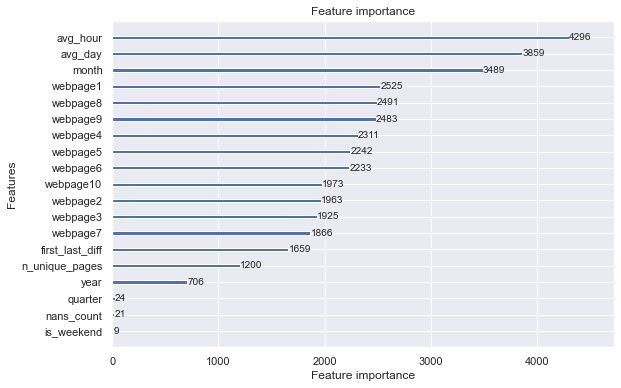

In [80]:
plot_importance(lgbm_2)

In [10]:
### less crossvalidation splits to reduce training time

In [111]:
skf_2 = StratifiedKFold(n_splits=3, shuffle=True, random_state=111) 

In [101]:
space = dict()
space['num_trees'] = randint(750,1100)
space['num_leaves'] = randint(25,40)
space['learning_rate'] = loguniform(0.01, 0.1)
space['boosting'] = ['gbdt', 'dart']
space['tree_learner'] = ['feature', 'data']
space['max_depth'] = [10,15,20,25,30,None]

In [112]:
lgbm_8 = RandomizedSearchCV(lgb_clf,
                    space,
                    scoring='roc_auc',
                    cv=skf_2,
                    n_iter=150,
                    n_jobs=1,
                    refit=True,
                    random_state=111,
                    verbose=2)

In [113]:
lgbm_8.fit(data_train_2, data_target)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[CV] END boosting=gbdt, learning_rate=0.013205589173603673, max_depth=30, num_leaves=31, num_trees=1025, tree_learner=data; total time=   9.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1025, num_trees=1025 will be ignored. Current value: num_iterations=1025
[CV] END boosting=gbdt, learning_rate=0.013205589173603673, max_depth=30, num_leaves=31, num_trees=1025, tree_learner=data; total time=   9.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1025, num_trees=1025 will be ignored. Current value: num_iterations=1025
[CV] 

[CV] END boosting=gbdt, learning_rate=0.09793881642413219, max_depth=25, num_leaves=33, num_trees=1010, tree_learner=data; total time=   8.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1010, num_trees=1010 will be ignored. Current value: num_iterations=1010
[CV] END boosting=gbdt, learning_rate=0.09793881642413219, max_depth=25, num_leaves=33, num_trees=1010, tree_learner=data; total time=   8.9s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1010, num_trees=1010 will be ignored. Current value: num_iterations=1010
[CV] END boosting=gbdt, learning_rate=0.09793881642413219, max_depth=2

[CV] END boosting=gbdt, learning_rate=0.010816259334462017, max_depth=15, num_leaves=32, num_trees=1056, tree_learner=feature; total time=   9.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1056, num_trees=1056 will be ignored. Current value: num_iterations=1056
[CV] END boosting=gbdt, learning_rate=0.010816259334462017, max_depth=15, num_leaves=32, num_trees=1056, tree_learner=feature; total time=  10.0s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1056, num_trees=1056 will be ignored. Current value: num_iterations=1056
[CV] END boosting=gbdt, learning_rate=0.010816259334462017, ma

[CV] END boosting=gbdt, learning_rate=0.027622830421009787, max_depth=25, num_leaves=36, num_trees=873, tree_learner=feature; total time=   8.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=873, num_trees=873 will be ignored. Current value: num_iterations=873
[CV] END boosting=gbdt, learning_rate=0.027622830421009787, max_depth=25, num_leaves=36, num_trees=873, tree_learner=feature; total time=   8.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=873, num_trees=873 will be ignored. Current value: num_iterations=873
[CV] END boosting=gbdt, learning_rate=0.027622830421009787, max_depth=

[CV] END boosting=gbdt, learning_rate=0.0159839281010412, max_depth=20, num_leaves=31, num_trees=1016, tree_learner=feature; total time=   9.3s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1016, num_trees=1016 will be ignored. Current value: num_iterations=1016
[CV] END boosting=gbdt, learning_rate=0.0159839281010412, max_depth=20, num_leaves=31, num_trees=1016, tree_learner=feature; total time=   9.5s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1016, num_trees=1016 will be ignored. Current value: num_iterations=1016
[CV] END boosting=gbdt, learning_rate=0.0159839281010412, max_dept

[CV] END boosting=dart, learning_rate=0.014766873431971835, max_depth=30, num_leaves=31, num_trees=858, tree_learner=feature; total time=  57.6s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=858, num_trees=858 will be ignored. Current value: num_iterations=858
[CV] END boosting=dart, learning_rate=0.014766873431971835, max_depth=30, num_leaves=31, num_trees=858, tree_learner=feature; total time=  57.0s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=858, num_trees=858 will be ignored. Current value: num_iterations=858
[CV] END boosting=dart, learning_rate=0.014766873431971835, max_depth=

[CV] END boosting=dart, learning_rate=0.04204451011016855, max_depth=30, num_leaves=30, num_trees=901, tree_learner=feature; total time= 4.1min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=901, num_trees=901 will be ignored. Current value: num_iterations=901
[CV] END boosting=dart, learning_rate=0.04204451011016855, max_depth=30, num_leaves=30, num_trees=901, tree_learner=feature; total time= 4.1min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=901, num_trees=901 will be ignored. Current value: num_iterations=901
[CV] END boosting=dart, learning_rate=0.04204451011016855, max_depth=30,

[CV] END boosting=dart, learning_rate=0.011797680472298027, max_depth=25, num_leaves=36, num_trees=955, tree_learner=data; total time= 3.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=955, num_trees=955 will be ignored. Current value: num_iterations=955
[CV] END boosting=dart, learning_rate=0.011797680472298027, max_depth=25, num_leaves=36, num_trees=955, tree_learner=data; total time= 3.4min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=955, num_trees=955 will be ignored. Current value: num_iterations=955
[CV] END boosting=dart, learning_rate=0.011797680472298027, max_depth=25, nu

[CV] END boosting=dart, learning_rate=0.07383470615868634, max_depth=10, num_leaves=37, num_trees=884, tree_learner=data; total time= 5.1min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=884, num_trees=884 will be ignored. Current value: num_iterations=884
[CV] END boosting=dart, learning_rate=0.07383470615868634, max_depth=10, num_leaves=37, num_trees=884, tree_learner=data; total time= 4.4min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=884, num_trees=884 will be ignored. Current value: num_iterations=884
[CV] END boosting=dart, learning_rate=0.07383470615868634, max_depth=10, num_l

[CV] END boosting=gbdt, learning_rate=0.015188984107126333, max_depth=20, num_leaves=39, num_trees=1026, tree_learner=feature; total time=  31.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1026, num_trees=1026 will be ignored. Current value: num_iterations=1026
[CV] END boosting=gbdt, learning_rate=0.015188984107126333, max_depth=20, num_leaves=39, num_trees=1026, tree_learner=feature; total time=  30.4s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1026, num_trees=1026 will be ignored. Current value: num_iterations=1026
[CV] END boosting=gbdt, learning_rate=0.015188984107126333, ma

[CV] END boosting=dart, learning_rate=0.029963866789531456, max_depth=25, num_leaves=27, num_trees=930, tree_learner=feature; total time= 3.4min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=930, num_trees=930 will be ignored. Current value: num_iterations=930
[CV] END boosting=dart, learning_rate=0.029963866789531456, max_depth=25, num_leaves=27, num_trees=930, tree_learner=feature; total time= 3.7min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=930, num_trees=930 will be ignored. Current value: num_iterations=930
[CV] END boosting=dart, learning_rate=0.029963866789531456, max_depth=

[CV] END boosting=dart, learning_rate=0.047183162754262854, max_depth=None, num_leaves=27, num_trees=836, tree_learner=data; total time= 1.3min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=836, num_trees=836 will be ignored. Current value: num_iterations=836
[CV] END boosting=dart, learning_rate=0.047183162754262854, max_depth=None, num_leaves=27, num_trees=836, tree_learner=data; total time= 1.4min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=836, num_trees=836 will be ignored. Current value: num_iterations=836
[CV] END boosting=dart, learning_rate=0.047183162754262854, max_depth=No

[CV] END boosting=dart, learning_rate=0.04453659085448019, max_depth=30, num_leaves=29, num_trees=1068, tree_learner=data; total time= 1.7min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1068, num_trees=1068 will be ignored. Current value: num_iterations=1068
[CV] END boosting=dart, learning_rate=0.04453659085448019, max_depth=30, num_leaves=29, num_trees=1068, tree_learner=data; total time= 1.8min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1068, num_trees=1068 will be ignored. Current value: num_iterations=1068
[CV] END boosting=dart, learning_rate=0.04453659085448019, max_depth=3

[CV] END boosting=gbdt, learning_rate=0.0884954334858691, max_depth=15, num_leaves=27, num_trees=769, tree_learner=data; total time=   6.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=769, num_trees=769 will be ignored. Current value: num_iterations=769
[CV] END boosting=gbdt, learning_rate=0.0884954334858691, max_depth=15, num_leaves=27, num_trees=769, tree_learner=data; total time=   6.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=769, num_trees=769 will be ignored. Current value: num_iterations=769
[CV] END boosting=gbdt, learning_rate=0.0884954334858691, max_depth=15, num_leav

[CV] END boosting=gbdt, learning_rate=0.017061008648626416, max_depth=20, num_leaves=27, num_trees=1087, tree_learner=feature; total time=   8.7s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1087, num_trees=1087 will be ignored. Current value: num_iterations=1087
[CV] END boosting=gbdt, learning_rate=0.017061008648626416, max_depth=20, num_leaves=27, num_trees=1087, tree_learner=feature; total time=   8.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1087, num_trees=1087 will be ignored. Current value: num_iterations=1087
[CV] END boosting=gbdt, learning_rate=0.017061008648626416, ma

[CV] END boosting=dart, learning_rate=0.04236193051151906, max_depth=15, num_leaves=30, num_trees=929, tree_learner=data; total time= 1.3min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=929, num_trees=929 will be ignored. Current value: num_iterations=929
[CV] END boosting=dart, learning_rate=0.04236193051151906, max_depth=15, num_leaves=30, num_trees=929, tree_learner=data; total time= 1.3min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=929, num_trees=929 will be ignored. Current value: num_iterations=929
[CV] END boosting=dart, learning_rate=0.04236193051151906, max_depth=15, num_l

[CV] END boosting=gbdt, learning_rate=0.06898695682273663, max_depth=15, num_leaves=26, num_trees=988, tree_learner=data; total time=   7.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=988, num_trees=988 will be ignored. Current value: num_iterations=988
[CV] END boosting=gbdt, learning_rate=0.06898695682273663, max_depth=15, num_leaves=26, num_trees=988, tree_learner=data; total time=   7.9s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=988, num_trees=988 will be ignored. Current value: num_iterations=988
[CV] END boosting=gbdt, learning_rate=0.06898695682273663, max_depth=15, num_l

[CV] END boosting=dart, learning_rate=0.010637681251728157, max_depth=15, num_leaves=34, num_trees=823, tree_learner=data; total time= 1.0min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=823, num_trees=823 will be ignored. Current value: num_iterations=823
[CV] END boosting=dart, learning_rate=0.010637681251728157, max_depth=15, num_leaves=34, num_trees=823, tree_learner=data; total time= 1.1min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=823, num_trees=823 will be ignored. Current value: num_iterations=823
[CV] END boosting=dart, learning_rate=0.010637681251728157, max_depth=15, nu

[CV] END boosting=gbdt, learning_rate=0.09906345024063498, max_depth=25, num_leaves=25, num_trees=817, tree_learner=feature; total time=   8.0s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=817, num_trees=817 will be ignored. Current value: num_iterations=817
[CV] END boosting=gbdt, learning_rate=0.09906345024063498, max_depth=25, num_leaves=25, num_trees=817, tree_learner=feature; total time=   6.4s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=817, num_trees=817 will be ignored. Current value: num_iterations=817
[CV] END boosting=gbdt, learning_rate=0.09906345024063498, max_depth=25,

[CV] END boosting=dart, learning_rate=0.018195249302460855, max_depth=None, num_leaves=30, num_trees=865, tree_learner=data; total time=  57.8s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=865, num_trees=865 will be ignored. Current value: num_iterations=865
[CV] END boosting=dart, learning_rate=0.018195249302460855, max_depth=None, num_leaves=30, num_trees=865, tree_learner=data; total time= 1.8min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=865, num_trees=865 will be ignored. Current value: num_iterations=865
[CV] END boosting=dart, learning_rate=0.018195249302460855, max_depth=No

[CV] END boosting=dart, learning_rate=0.014053650670711309, max_depth=30, num_leaves=38, num_trees=949, tree_learner=data; total time= 3.1min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=949, num_trees=949 will be ignored. Current value: num_iterations=949
[CV] END boosting=dart, learning_rate=0.014053650670711309, max_depth=30, num_leaves=38, num_trees=949, tree_learner=data; total time= 3.2min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=949, num_trees=949 will be ignored. Current value: num_iterations=949
[CV] END boosting=dart, learning_rate=0.014053650670711309, max_depth=30, nu

[CV] END boosting=gbdt, learning_rate=0.02733030210433745, max_depth=10, num_leaves=26, num_trees=758, tree_learner=data; total time=  10.1s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=758, num_trees=758 will be ignored. Current value: num_iterations=758
[CV] END boosting=gbdt, learning_rate=0.02733030210433745, max_depth=10, num_leaves=26, num_trees=758, tree_learner=data; total time=   9.9s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=758, num_trees=758 will be ignored. Current value: num_iterations=758
[CV] END boosting=gbdt, learning_rate=0.02733030210433745, max_depth=10, num_l

[CV] END boosting=gbdt, learning_rate=0.023447580775254214, max_depth=15, num_leaves=36, num_trees=1068, tree_learner=data; total time=  15.6s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1068, num_trees=1068 will be ignored. Current value: num_iterations=1068
[CV] END boosting=gbdt, learning_rate=0.023447580775254214, max_depth=15, num_leaves=36, num_trees=1068, tree_learner=data; total time=  15.8s
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=1068, num_trees=1068 will be ignored. Current value: num_iterations=1068
[CV] END boosting=gbdt, learning_rate=0.023447580775254214, max_dept

[CV] END boosting=dart, learning_rate=0.02731407030679843, max_depth=25, num_leaves=37, num_trees=901, tree_learner=feature; total time= 1.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=901, num_trees=901 will be ignored. Current value: num_iterations=901
[CV] END boosting=dart, learning_rate=0.02731407030679843, max_depth=25, num_leaves=37, num_trees=901, tree_learner=feature; total time= 1.6min
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=901, num_trees=901 will be ignored. Current value: num_iterations=901
[CV] END boosting=dart, learning_rate=0.02731407030679843, max_depth=25,

[CV] END boosting=dart, learning_rate=0.044640415797738496, max_depth=25, num_leaves=28, num_trees=782, tree_learner=feature; total time=  58.7s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=782, num_trees=782 will be ignored. Current value: num_iterations=782
[CV] END boosting=dart, learning_rate=0.044640415797738496, max_depth=25, num_leaves=28, num_trees=782, tree_learner=feature; total time=  59.5s
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=782, num_trees=782 will be ignored. Current value: num_iterations=782
[CV] END boosting=dart, learning_rate=0.044640415797738496, max_depth=

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=111, shuffle=True),
                   estimator=LGBMClassifier(num_threads=2, objective='binary'),
                   n_iter=150, n_jobs=1,
                   param_distributions={'boosting': ['gbdt', 'dart'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F80229A5E0>,
                                        'max_depth': [10, 15, 20, 25, 30, None],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F80229A070>,
                                        'num_trees': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F80229A0A0>,
                                        'tree_learner': ['feature', 'data']},
                   random_state=111, scoring='roc_auc', verbose=2)

In [115]:
lgbm_8.best_params_

{'boosting': 'dart',
 'learning_rate': 0.06845149509984495,
 'max_depth': None,
 'num_leaves': 34,
 'num_trees': 848,
 'tree_learner': 'data'}

In [120]:
lgbm_9 = LGBMClassifier(objective='binary', random_state=1, num_threads=2, boosting= 'dart',
 learning_rate = 0.06,
 num_leaves = 35,
  num_trees =  850,
 tree_learner = 'data')

In [121]:
lgbm_9.fit(data_train_2, data_target)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=850, num_trees=850 will be ignored. Current value: num_iterations=850


LGBMClassifier(boosting='dart', learning_rate=0.06, num_leaves=35,
               num_threads=2, num_trees=850, objective='binary', random_state=1,
               tree_learner='data')

In [123]:
lgbm_10 = LGBMClassifier(objective='binary', random_state=1, num_threads=2, boosting= 'dart',
 learning_rate = 0.06,
 num_leaves = 36,
  num_trees =  855,
 tree_learner = 'data')

In [124]:
lgbm_10.fit(data_train_2, data_target)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=855, num_trees=855 will be ignored. Current value: num_iterations=855


LGBMClassifier(boosting='dart', learning_rate=0.06, num_leaves=36,
               num_threads=2, num_trees=855, objective='binary', random_state=1,
               tree_learner='data')

In [141]:
lgbm_11 = LGBMClassifier(objective='binary', random_state=1, num_threads=2, 
    boosting= 'dart',
    learning_rate = 0.061,
    num_leaves = 36,
    num_trees =  860,
    tree_learner = 'data') # best so far - try increasing learning rate a bit more !!!

In [142]:
lgbm_11.fit(data_train_2, data_target)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=860, num_trees=860 will be ignored. Current value: num_iterations=860


LGBMClassifier(boosting='dart', learning_rate=0.061, num_leaves=36,
               num_threads=2, num_trees=860, objective='binary', random_state=1,
               tree_learner='data')

In [147]:
lgbm_12 = LGBMClassifier(objective='binary', random_state=1, num_threads=2, 
    boosting= 'dart',
    learning_rate = 0.0615,
    num_leaves = 36,
    num_trees =  860,
    tree_learner = 'data')

In [148]:
lgbm_12.fit(data_train_2, data_target)

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] num_iterations is set=860, num_trees=860 will be ignored. Current value: num_iterations=860


LGBMClassifier(boosting='dart', learning_rate=0.0615, num_leaves=36,
               num_threads=2, num_trees=860, objective='binary', random_state=1,
               tree_learner='data')

#### Saving

In [166]:
def save_submission(pred):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv('notebook_submission_32.csv')
pred = lgbm_12.predict_proba(data_test_2)[:, 1]
save_submission(pred)